In [35]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers

In [53]:
df = pd.read_csv("Merged_Finall.csv")
df = df[df["Date"] > "2014-01-01"]
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timestamp,FinalScore
248,249,Bitcoin,BTC,2014-01-02,820.309998,767.210022,773.440002,802.390015,3.848950e+07,9.781074e+09,2014-01-02,0.113551
249,250,Bitcoin,BTC,2014-01-03,834.150024,789.119995,802.849976,818.719971,3.781010e+07,9.980135e+09,2014-01-03,0.551178
250,251,Bitcoin,BTC,2014-01-04,859.510010,801.669983,823.270020,859.510010,3.800500e+07,1.047736e+10,2014-01-04,0.152116
251,252,Bitcoin,BTC,2014-01-05,952.400024,854.520020,858.549988,933.530029,7.289850e+07,1.137966e+10,2014-01-05,0.133873
252,253,Bitcoin,BTC,2014-01-06,1017.119995,905.710022,936.049988,953.289978,8.556570e+07,1.162053e+10,2014-01-06,-1.052030
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,Bitcoin,BTC,2019-11-19,8408.516128,8099.963369,8305.134291,8206.145918,2.108361e+10,1.481784e+11,2019-11-19,266.234714
2396,2397,Bitcoin,BTC,2019-11-20,8237.239874,8010.511901,8203.613180,8027.268243,2.076430e+10,1.449627e+11,2019-11-20,10.221575
2397,2398,Bitcoin,BTC,2019-11-21,8110.098131,7597.381608,8023.644687,7642.749945,2.251424e+10,1.380319e+11,2019-11-21,-8503.435071
2398,2399,Bitcoin,BTC,2019-11-22,7697.382714,6936.706599,7643.569425,7296.577568,3.424232e+10,1.317918e+11,2019-11-22,15.649639


In [54]:
train_dates = pd.to_datetime(df['Date'])

In [55]:
df_for_training = df[["Close", "Volume", "FinalScore"]]
df_for_training

,Close,Volume,FinalScore
248,802.390015,3.848950e+07,0.113551
249,818.719971,3.781010e+07,0.551178
250,859.510010,3.800500e+07,0.152116
251,933.530029,7.289850e+07,0.133873
252,953.289978,8.556570e+07,-1.052030
...,...,...,...
2395,8206.145918,2.108361e+10,266.234714
2396,8027.268243,2.076430e+10,10.221575
2397,7642.749945,2.251424e+10,-8503.435071
2398,7296.577568,3.424232e+10,15.649639


In [56]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [122]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 1  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0]) #0 means our label class in 1st column.

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2151, 1, 3).
trainY shape == (2151, 1).


In [123]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 50)                10800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
27/27 [==============================] - 1s 8ms/step - loss: 0.8718 - val_loss: 1.1730
Epoch 2/100
27/27 [==============================] - 0s 1ms/step - loss: 0.6709 - val_loss: 0.7884
Epoch 3/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4572 - val_loss: 0.4287
Epoch 4/100
27/27 [==============================] - 0s 1ms/step - loss: 0.3181 - val_loss: 0.1534
Epoch 5/100
27/27 [==============================] - 0s 1ms/step - loss: 0.1667 - val_loss: 0.0780
Epoch 6/100
27/27 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.1934
Epoch 7/100
27/27 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.3552
Epoch 8/100
27/27 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.4251
Epoch 9/100
27/27 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.4108
Epoch 10/100
27/27 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.3770
Epoch 11/

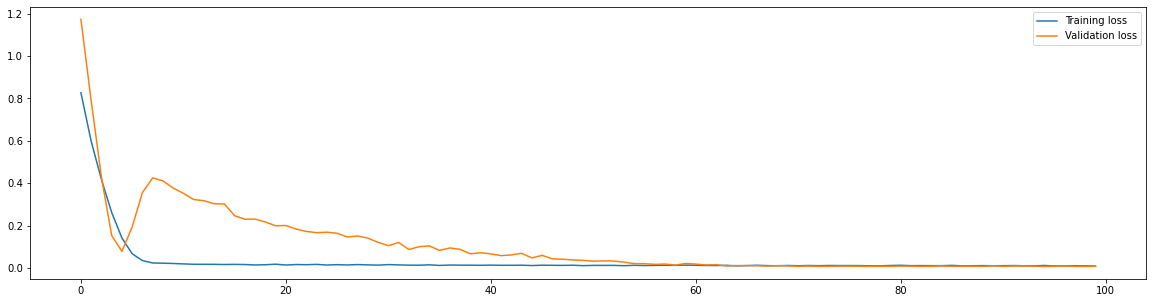

In [124]:
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [125]:
n_past = 16
n_days_for_prediction = 15

In [126]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2019-11-08 00:00:00', freq='D'), Timestamp('2019-11-09 00:00:00', freq='D'), Timestamp('2019-11-10 00:00:00', freq='D'), Timestamp('2019-11-11 00:00:00', freq='D'), Timestamp('2019-11-12 00:00:00', freq='D'), Timestamp('2019-11-13 00:00:00', freq='D'), Timestamp('2019-11-14 00:00:00', freq='D'), Timestamp('2019-11-15 00:00:00', freq='D'), Timestamp('2019-11-16 00:00:00', freq='D'), Timestamp('2019-11-17 00:00:00', freq='D'), Timestamp('2019-11-18 00:00:00', freq='D'), Timestamp('2019-11-19 00:00:00', freq='D'), Timestamp('2019-11-20 00:00:00', freq='D'), Timestamp('2019-11-21 00:00:00', freq='D'), Timestamp('2019-11-22 00:00:00', freq='D')]


In [127]:
prediction = model.predict(trainX[-n_days_for_prediction:]) 

In [128]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [129]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [130]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [131]:
df_forecast

,Date,Close
0,2019-11-08,8572.608398
1,2019-11-09,8758.331055
2,2019-11-10,8920.575195
3,2019-11-11,8641.264648
4,2019-11-12,8695.986328
5,2019-11-13,8753.823242
6,2019-11-14,8622.599609
7,2019-11-15,8347.220703
8,2019-11-16,8521.264648
9,2019-11-17,8504.264648


In [132]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2019-11-08']

/tmp/ipykernel_1483922/377699816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


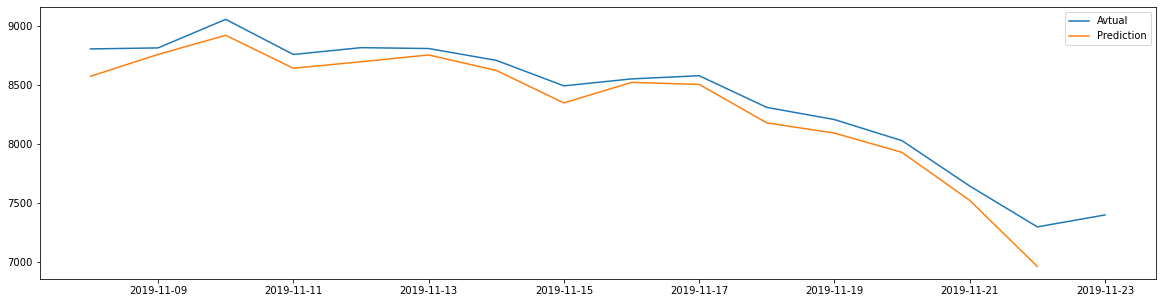

In [133]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(original['Date'], original['Close'], label = "Avtual")
plt.plot(df_forecast['Date'], df_forecast['Close'], label = "Prediction")
plt.legend()